In [1]:
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image

from model.generator import Generator
# from model.networks_tf import Generator
# from model.networks import Generator

plt.rcParams['figure.facecolor'] = 'white'

## Load generator model


In [2]:
use_cuda_if_available = False
device = torch.device('cuda' if torch.cuda.is_available() and use_cuda_if_available else 'cpu')

sd_path = 'pretrained/states_tf_places2.pth'
# sd_path = 'pretrained/states_pt_places2.pth'

generator = Generator(checkpoint=sd_path, return_flow=True).to(device)

## Load image and mask


In [3]:
n = 1
image_path = f"examples/inpaint/case{n}.png"
mask_path = f"examples/inpaint/case{n}_mask.png"

image_pil = Image.open(image_path)
mask_pil = Image.open(mask_path)

## Plot raw image and mask


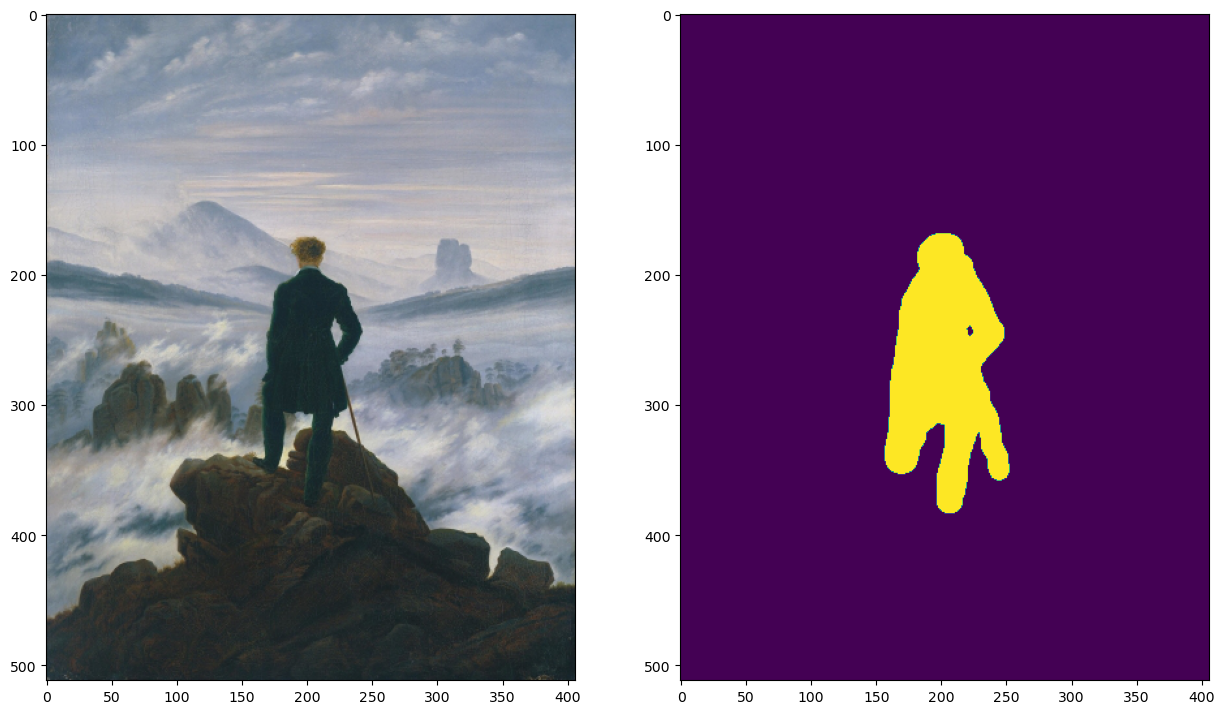

In [4]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
ax1.imshow(image_pil)  # plot raw image
ax2.imshow(mask_pil.convert('L'))   # plot mask
plt.show()

## Inpaint

In [5]:
image = T.ToTensor()(image_pil).to(device)
mask = T.ToTensor()(mask_pil).to(device)

output = generator.predict(image, mask, return_vals=['inpainted', 'stage1', 'stage2', 'flow'])


RuntimeError: The size of tensor a (150) must match the size of tensor b (400) at non-singleton dimension 3

## Results


In [ ]:
mask = (mask[0:1] > 0.).to(dtype=torch.float32)
image_masked = (image*(1-mask)).permute(1, 2, 0).cpu()

print("Result:")
plt.figure(figsize=(10, 8))
plt.imshow(output[0])
plt.show()

w, h = image_pil.size

print("""| Raw | Masked |
| Stage1 | Stage2 |""")
_, axes = plt.subplots(2, 2, figsize=(15*w / max(w,h), 15*h / max(w,h)))
axes[0,0].imshow(image_pil)
axes[0,1].imshow(image_masked)
axes[1,0].imshow(output[1])
axes[1,1].imshow(output[2])
plt.show()

### Plot attention flow map


In [ ]:
plt.imshow(output[3][0].cpu().permute(1, 2, 0))

## Test Contextual Attention


In [ ]:

from model.networks import ContextualAttention
#from model.networks_tf import ContextualAttention


contextual_attention = ContextualAttention(ksize=3, stride=1, rate=2, 
                                           fuse_k=3, softmax_scale=10, 
                                           fuse=False,
                                           return_flow=True)

imageB = 'examples/style_transfer/bike.jpg'
imageA = 'examples/style_transfer/bnw_butterfly.png'

def test_contextual_attention(imageA, imageB):
    """Test contextual attention layer with 3-channel image input
    (instead of n-channel feature).
    
    """
    rate = 2
    stride = 1
    grid = rate*stride
    
    b = Image.open(imageA)
    b = b.resize((b.width//2, b.height//2), resample=Image.BICUBIC)
    b = T.ToTensor()(b)

    _, h, w = b.shape
    b = b[:, :h//grid*grid, :w//grid*grid].unsqueeze(0)

    print(f"Size of imageA: {b.shape}")

    f = T.ToTensor()(Image.open(imageB)) 
    _, h, w = f.shape
    f = f[:, :h//grid*grid, :w//grid*grid].unsqueeze(0)
 
    print(f"Size of imageB: {f.shape}")   

    yt, flow = contextual_attention(f*255., b*255.)

    return yt, flow


yt, flow = test_contextual_attention(imageA, imageB)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
ax1.imshow(yt[0].permute(1, 2, 0)/255.)
ax2.imshow(flow[0].permute(1, 2, 0))
